# Multilayer perceptron

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline 

See MIT License in 
https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 [Online.](https://arxiv.org/abs/1611.06455 "Wang et al. (2017)")

## Formatting

Left align the tables in this Notebook.


In [221]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Data
Additional datasets are available in the UEA & UCT Time Series Classification Repository at http://www.timeseriesclassification.com/. 

Save additional datasets in deepscent/data. E.g. deepscent/data/Adiac/Adiac_TRAIN.txt

### GunPoint dataset
The GunPoint dataset is from the [UEA & UCR Time Series 
Classification Repository](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint 
"GunPoint description"). The data is from one female and one male either drawing and pointing a gun at a target or pointing their finger at a target. The location of their hand was tracked. This data is the time series of the x-axis location.

|Training set size |Test set size |Number of classes 
|:-----------      |:--------     |:----------     
|50 |150  |2 


## Train MLP
Expected running time for various datasets when using the original training/test split. Running on a single NVIDIA GeForce GTX 1080 Ti Graphics Card -

Dataset   | Training time
:-------  | :--------
Adiac     | 18 minutes
GunPoint  | 11 minutes


### User inputs

In [222]:
from datetime import datetime

flist = ['GunPoint'] # List dataset directory names.
batch_size = 64 # Or Wang setting can be set below as int(min(x_train.shape[0]/10, 16)) 
nb_epochs = 5000
k = 1 # For k-fold cross validation. If k=1, the original test-train split is used.
m = 1 # Number of repetitions of k-fold cross validation (if k>1).
seed = 35 # seed for initialising random weights in the NN.
k_fold_seed = 87
tensorboard = False # Set to True to write logs for use by TensorBoard
# Directories
fdir = '../data'  
logs_dir = '../logs'
tensorboard_dir = '../logs/tensorboard'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp

### Set up

In [223]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RepeatedKFold

import os
import pathlib
import time

np.random.seed(22)#813306)
      
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
  

### Visualise the data

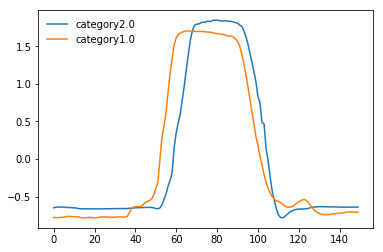

In [224]:
fname = flist[0]
data_a = 0
data_b = 2
x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
plt.plot(x_train[data_a], label='category'+str(y_train[data_a]))
plt.plot(x_train[data_b], label='category'+str(y_train[data_b]))
plt.legend(loc='upper left', frameon=False)

### Function to train the MLP

In [225]:
def train_model(fname, x_train, y_train, x_test, y_test, label="0"):
    print('Running dataset', fname)
    nb_classes =len(np.unique(y_test))
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
    #batch_size = int(min(x_train.shape[0]/10, 16)) # Wang et al. setting.
    
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
    x_test = (x_test - x_train_mean)/(x_train_std)
     
    if True:    
        model = Sequential()
        #model.add(Dropout(0.1, input_shape=(x_train.shape[1],),name='Drop01'))
        #model.add(Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed)))
        model.add(Dense(500, input_shape=(x_train.shape[1],), activation='relu', kernel_initializer=RandomUniform(seed=seed)))
        model.add(Dropout(0.2,name='Drop02'))
        model.add(Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed)))
        model.add(Dropout(0.2,name='Drop02a'))
        model.add(Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed)))
        model.add(Dropout(0.3,name='Drop03'))
        model.add(Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed)))
        #print(model.summary())
    else:
        x = Input(x_train.shape[1:])
        #y= Dropout(0.1,name='Drop01')(x)
        y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(x)
        y = Dropout(0.2,name='Drop02')(y)
        y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(y)
        y = Dropout(0.2,name='Drop02a')(y)
        y = Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed))(y)
        y = Dropout(0.3,name='Drop03')(y)
        out = Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed))(y)
        model = Model(x, out)
        #print(model.summary())
    
    optimizer = keras.optimizers.Adadelta(rho=0.95, epsilon=1e-8)  
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=200, min_lr=0.1)
    callbacks = [reduce_lr]
    if tensorboard:
        callbacks = [reduce_lr, keras.callbacks.TensorBoard(log_dir=tensorboard_dir+'/'+fname+'_'+label, histogram_freq=0)]

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=2, validation_data=(x_test, Y_test), callbacks=callbacks)
    end = time.time()
    
    log = pd.DataFrame(hist.history)   
    # Print results. Print the testing results which has the lowest training loss.
    print('Training complete on', fname)
    duration_minutes = str(round((end-start)/60))
    print('Training time ', end-start, 'seconds, which is about', duration_minutes, 'minutes.')    
    print('Selected the test result with the lowest training loss. Loss and validation accuracy are -')
    idx = log['loss'].idxmin()
    loss = log.loc[log['loss'].idxmin]['loss']
    val_acc = log.loc[log['loss'].idxmin]['val_acc']
    print(loss, val_acc, 'at index', str(idx), ' (epoch ', str(idx+1), ')')
    summary = '|' + label + '  |'+str(loss)+'  |'+str(val_acc)+' |'+str(idx)+' |'+ duration_minutes + 'mins  |'
    summary_csv = label+','+str(loss)+','+str(val_acc)+','+str(idx)+','+ duration_minutes 
    # Save summary file and log file.
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    with open(logs_dir+'/'+fname+'/summary.csv', 'a+') as f:
        f.write(summary_csv)
        f.write('\n')
        print('Added summary row to ', logs_dir+'/'+fname+'/summary.csv')  
    print('Saving logs to',logs_dir+'/'+fname+'/history_'+label+'.csv')
    log.to_csv(logs_dir+'/'+fname+'/history_'+label+'.csv')
    return summary, model
 



# Train

In [226]:
results = []
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        kfold = RepeatedKFold(n_splits=k, n_repeats=m, random_state=k_fold_seed)
        count = 0
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            summary, model = train_model(fname, x_train, y_train, x_test, y_test, str(count))
            results.append(summary)
            count = count + 1
    else:
        summary, model = train_model(fname, x_train, y_train, x_test, y_test)
        results.append(summary)

        
print('DONE')
print(fname, timestamp)
for each in results:
    print(each)
print('Example prediction probabilities')
y_predict = model.predict_proba(x_test)            
for yp in y_predict[1:20]:
    print(yp)

Running dataset GunPoint
Train on 50 samples, validate on 150 samples
Epoch 1/5000
 - 2s - loss: 0.6996 - acc: 0.4200 - val_loss: 0.6865 - val_acc: 0.6333
Epoch 2/5000
 - 0s - loss: 0.6838 - acc: 0.7200 - val_loss: 0.6772 - val_acc: 0.6333
Epoch 3/5000
 - 0s - loss: 0.6691 - acc: 0.8000 - val_loss: 0.6661 - val_acc: 0.7600
Epoch 4/5000
 - 0s - loss: 0.6543 - acc: 0.8200 - val_loss: 0.6551 - val_acc: 0.7067
Epoch 5/5000
 - 0s - loss: 0.6472 - acc: 0.8400 - val_loss: 0.6415 - val_acc: 0.7067
Epoch 6/5000
 - 0s - loss: 0.6228 - acc: 0.9000 - val_loss: 0.6221 - val_acc: 0.8000
Epoch 7/5000
 - 0s - loss: 0.6034 - acc: 0.8200 - val_loss: 0.6072 - val_acc: 0.6667
Epoch 8/5000
 - 0s - loss: 0.5664 - acc: 0.8200 - val_loss: 0.5804 - val_acc: 0.7733
Epoch 9/5000
 - 0s - loss: 0.5276 - acc: 0.8600 - val_loss: 0.5699 - val_acc: 0.6667
Epoch 10/5000
 - 0s - loss: 0.5178 - acc: 0.7400 - val_loss: 0.6122 - val_acc: 0.6400
Epoch 11/5000
 - 0s - loss: 0.5495 - acc: 0.6800 - val_loss: 0.6744 - val_acc: 

Epoch 96/5000
 - 0s - loss: 0.1371 - acc: 0.9400 - val_loss: 0.3299 - val_acc: 0.8400
Epoch 97/5000
 - 0s - loss: 0.1247 - acc: 0.9400 - val_loss: 0.3594 - val_acc: 0.8400
Epoch 98/5000
 - 0s - loss: 0.1225 - acc: 0.9600 - val_loss: 0.3477 - val_acc: 0.8267
Epoch 99/5000
 - 0s - loss: 0.1303 - acc: 0.9400 - val_loss: 0.5538 - val_acc: 0.7133
Epoch 100/5000
 - 0s - loss: 0.1876 - acc: 0.8600 - val_loss: 0.6678 - val_acc: 0.7333
Epoch 101/5000
 - 0s - loss: 0.3372 - acc: 0.8600 - val_loss: 0.4205 - val_acc: 0.7467
Epoch 102/5000
 - 0s - loss: 0.1648 - acc: 0.8800 - val_loss: 0.3467 - val_acc: 0.8000
Epoch 103/5000
 - 0s - loss: 0.1494 - acc: 0.9000 - val_loss: 0.3479 - val_acc: 0.8533
Epoch 104/5000
 - 0s - loss: 0.1191 - acc: 0.9800 - val_loss: 0.3179 - val_acc: 0.8533
Epoch 105/5000
 - 0s - loss: 0.1086 - acc: 0.9600 - val_loss: 0.4264 - val_acc: 0.8067
Epoch 106/5000
 - 0s - loss: 0.1376 - acc: 0.9400 - val_loss: 0.4964 - val_acc: 0.7667
Epoch 107/5000
 - 0s - loss: 0.2367 - acc: 0.88

Epoch 191/5000
 - 0s - loss: 0.1234 - acc: 0.9400 - val_loss: 0.4511 - val_acc: 0.8267
Epoch 192/5000
 - 0s - loss: 0.1154 - acc: 0.9200 - val_loss: 0.5041 - val_acc: 0.7867
Epoch 193/5000
 - 0s - loss: 0.1910 - acc: 0.8800 - val_loss: 0.3147 - val_acc: 0.9000
Epoch 194/5000
 - 0s - loss: 0.0647 - acc: 0.9800 - val_loss: 0.2490 - val_acc: 0.9133
Epoch 195/5000
 - 0s - loss: 0.0615 - acc: 1.0000 - val_loss: 0.3071 - val_acc: 0.9067
Epoch 196/5000
 - 0s - loss: 0.0545 - acc: 1.0000 - val_loss: 0.2501 - val_acc: 0.9133
Epoch 197/5000
 - 0s - loss: 0.0373 - acc: 1.0000 - val_loss: 0.2998 - val_acc: 0.9133
Epoch 198/5000
 - 0s - loss: 0.0362 - acc: 1.0000 - val_loss: 0.2481 - val_acc: 0.9133
Epoch 199/5000
 - 0s - loss: 0.0376 - acc: 0.9800 - val_loss: 0.2998 - val_acc: 0.9133
Epoch 200/5000
 - 0s - loss: 0.0434 - acc: 0.9800 - val_loss: 0.2690 - val_acc: 0.9200
Epoch 201/5000
 - 0s - loss: 0.0503 - acc: 0.9800 - val_loss: 0.4005 - val_acc: 0.8667
Epoch 202/5000
 - 0s - loss: 0.0768 - acc: 

 - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.3099 - val_acc: 0.9333
Epoch 286/5000
 - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.2809 - val_acc: 0.9267
Epoch 287/5000
 - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.2830 - val_acc: 0.9267
Epoch 288/5000
 - 0s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2855 - val_acc: 0.9267
Epoch 289/5000
 - 0s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.2800 - val_acc: 0.9467
Epoch 290/5000
 - 0s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2753 - val_acc: 0.9467
Epoch 291/5000
 - 0s - loss: 0.0060 - acc: 1.0000 - val_loss: 0.2768 - val_acc: 0.9467
Epoch 292/5000
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.2773 - val_acc: 0.9400
Epoch 293/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.2763 - val_acc: 0.9400
Epoch 294/5000
 - 0s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.2701 - val_acc: 0.9400
Epoch 295/5000
 - 0s - loss: 0.0174 - acc: 0.9800 - val_loss: 0.4224 - val_acc: 0.9000
Epoch 296/5000
 - 0s - loss: 0.0333 - acc: 0.9800 - val_lo

Epoch 379/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.9333
Epoch 380/5000
 - 0s - loss: 8.3787e-04 - acc: 1.0000 - val_loss: 0.3437 - val_acc: 0.9267
Epoch 381/5000
 - 0s - loss: 9.0442e-04 - acc: 1.0000 - val_loss: 0.3454 - val_acc: 0.9333
Epoch 382/5000
 - 0s - loss: 8.4985e-04 - acc: 1.0000 - val_loss: 0.3424 - val_acc: 0.9267
Epoch 383/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.3486 - val_acc: 0.9267
Epoch 384/5000
 - 0s - loss: 6.6718e-04 - acc: 1.0000 - val_loss: 0.3482 - val_acc: 0.9333
Epoch 385/5000
 - 0s - loss: 4.4575e-04 - acc: 1.0000 - val_loss: 0.3473 - val_acc: 0.9267
Epoch 386/5000
 - 0s - loss: 5.8902e-04 - acc: 1.0000 - val_loss: 0.3458 - val_acc: 0.9333
Epoch 387/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3658 - val_acc: 0.9333
Epoch 388/5000
 - 0s - loss: 4.9571e-04 - acc: 1.0000 - val_loss: 0.3603 - val_acc: 0.9400
Epoch 389/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.3858 - val_acc: 0.9200
Epoch 390/5000


Epoch 470/5000
 - 0s - loss: 1.8533e-04 - acc: 1.0000 - val_loss: 0.3746 - val_acc: 0.9467
Epoch 471/5000
 - 0s - loss: 7.3070e-04 - acc: 1.0000 - val_loss: 0.3883 - val_acc: 0.9467
Epoch 472/5000
 - 0s - loss: 1.3109e-04 - acc: 1.0000 - val_loss: 0.3922 - val_acc: 0.9400
Epoch 473/5000
 - 0s - loss: 1.1368e-04 - acc: 1.0000 - val_loss: 0.3890 - val_acc: 0.9400
Epoch 474/5000
 - 0s - loss: 3.5705e-04 - acc: 1.0000 - val_loss: 0.3929 - val_acc: 0.9467
Epoch 475/5000
 - 0s - loss: 3.1949e-04 - acc: 1.0000 - val_loss: 0.3834 - val_acc: 0.9467
Epoch 476/5000
 - 0s - loss: 1.9557e-04 - acc: 1.0000 - val_loss: 0.3865 - val_acc: 0.9400
Epoch 477/5000
 - 0s - loss: 1.3739e-04 - acc: 1.0000 - val_loss: 0.3835 - val_acc: 0.9467
Epoch 478/5000
 - 0s - loss: 1.8322e-04 - acc: 1.0000 - val_loss: 0.3849 - val_acc: 0.9467
Epoch 479/5000
 - 0s - loss: 3.7030e-04 - acc: 1.0000 - val_loss: 0.3793 - val_acc: 0.9400
Epoch 480/5000
 - 0s - loss: 3.0741e-04 - acc: 1.0000 - val_loss: 0.3866 - val_acc: 0.9467

 - 0s - loss: 2.4712e-04 - acc: 1.0000 - val_loss: 0.4164 - val_acc: 0.9467
Epoch 561/5000
 - 0s - loss: 2.0898e-04 - acc: 1.0000 - val_loss: 0.4075 - val_acc: 0.9467
Epoch 562/5000
 - 0s - loss: 1.9237e-04 - acc: 1.0000 - val_loss: 0.4104 - val_acc: 0.9467
Epoch 563/5000
 - 0s - loss: 5.1370e-05 - acc: 1.0000 - val_loss: 0.4107 - val_acc: 0.9467
Epoch 564/5000
 - 0s - loss: 6.6130e-05 - acc: 1.0000 - val_loss: 0.4103 - val_acc: 0.9467
Epoch 565/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.3688 - val_acc: 0.9200
Epoch 566/5000
 - 0s - loss: 3.9455e-04 - acc: 1.0000 - val_loss: 0.3212 - val_acc: 0.9467
Epoch 567/5000
 - 0s - loss: 1.7927e-04 - acc: 1.0000 - val_loss: 0.3154 - val_acc: 0.9467
Epoch 568/5000
 - 0s - loss: 1.4215e-04 - acc: 1.0000 - val_loss: 0.3230 - val_acc: 0.9467
Epoch 569/5000
 - 0s - loss: 7.3832e-05 - acc: 1.0000 - val_loss: 0.3235 - val_acc: 0.9467
Epoch 570/5000
 - 0s - loss: 3.2992e-04 - acc: 1.0000 - val_loss: 0.3387 - val_acc: 0.9467
Epoch 571/5000
 - 

Epoch 651/5000
 - 0s - loss: 6.7618e-05 - acc: 1.0000 - val_loss: 0.3914 - val_acc: 0.9467
Epoch 652/5000
 - 0s - loss: 1.8882e-04 - acc: 1.0000 - val_loss: 0.3841 - val_acc: 0.9467
Epoch 653/5000
 - 0s - loss: 5.5016e-05 - acc: 1.0000 - val_loss: 0.3817 - val_acc: 0.9467
Epoch 654/5000
 - 0s - loss: 2.9229e-04 - acc: 1.0000 - val_loss: 0.4153 - val_acc: 0.9333
Epoch 655/5000
 - 0s - loss: 1.0707e-04 - acc: 1.0000 - val_loss: 0.4022 - val_acc: 0.9333
Epoch 656/5000
 - 0s - loss: 7.3572e-05 - acc: 1.0000 - val_loss: 0.3966 - val_acc: 0.9467
Epoch 657/5000
 - 0s - loss: 5.4822e-05 - acc: 1.0000 - val_loss: 0.3936 - val_acc: 0.9467
Epoch 658/5000
 - 0s - loss: 1.5689e-04 - acc: 1.0000 - val_loss: 0.4104 - val_acc: 0.9333
Epoch 659/5000
 - 0s - loss: 4.8698e-05 - acc: 1.0000 - val_loss: 0.4062 - val_acc: 0.9333
Epoch 660/5000
 - 0s - loss: 1.1089e-04 - acc: 1.0000 - val_loss: 0.4020 - val_acc: 0.9467
Epoch 661/5000
 - 0s - loss: 1.6958e-04 - acc: 1.0000 - val_loss: 0.4154 - val_acc: 0.9333

 - 0s - loss: 3.2871e-05 - acc: 1.0000 - val_loss: 0.3971 - val_acc: 0.9467
Epoch 742/5000
 - 0s - loss: 3.0797e-05 - acc: 1.0000 - val_loss: 0.3963 - val_acc: 0.9467
Epoch 743/5000
 - 0s - loss: 2.8631e-04 - acc: 1.0000 - val_loss: 0.3999 - val_acc: 0.9467
Epoch 744/5000
 - 0s - loss: 8.4109e-05 - acc: 1.0000 - val_loss: 0.3993 - val_acc: 0.9467
Epoch 745/5000
 - 0s - loss: 3.9117e-05 - acc: 1.0000 - val_loss: 0.3977 - val_acc: 0.9467
Epoch 746/5000
 - 0s - loss: 2.6321e-05 - acc: 1.0000 - val_loss: 0.3980 - val_acc: 0.9467
Epoch 747/5000
 - 0s - loss: 1.6422e-04 - acc: 1.0000 - val_loss: 0.3983 - val_acc: 0.9467
Epoch 748/5000
 - 0s - loss: 1.7404e-05 - acc: 1.0000 - val_loss: 0.3980 - val_acc: 0.9467
Epoch 749/5000
 - 0s - loss: 3.5598e-05 - acc: 1.0000 - val_loss: 0.3970 - val_acc: 0.9467
Epoch 750/5000
 - 0s - loss: 6.0943e-05 - acc: 1.0000 - val_loss: 0.3936 - val_acc: 0.9467
Epoch 751/5000
 - 0s - loss: 3.2898e-05 - acc: 1.0000 - val_loss: 0.3956 - val_acc: 0.9467
Epoch 752/5000

Epoch 832/5000
 - 0s - loss: 4.6955e-05 - acc: 1.0000 - val_loss: 0.4087 - val_acc: 0.9467
Epoch 833/5000
 - 0s - loss: 1.4932e-04 - acc: 1.0000 - val_loss: 0.4170 - val_acc: 0.9467
Epoch 834/5000
 - 0s - loss: 6.3365e-05 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.9467
Epoch 835/5000
 - 0s - loss: 4.5015e-05 - acc: 1.0000 - val_loss: 0.4188 - val_acc: 0.9467
Epoch 836/5000
 - 0s - loss: 7.6305e-05 - acc: 1.0000 - val_loss: 0.4121 - val_acc: 0.9467
Epoch 837/5000
 - 0s - loss: 3.1845e-05 - acc: 1.0000 - val_loss: 0.4122 - val_acc: 0.9467
Epoch 838/5000
 - 0s - loss: 3.7601e-05 - acc: 1.0000 - val_loss: 0.4108 - val_acc: 0.9467
Epoch 839/5000
 - 0s - loss: 5.3051e-05 - acc: 1.0000 - val_loss: 0.4077 - val_acc: 0.9467
Epoch 840/5000
 - 0s - loss: 2.7679e-05 - acc: 1.0000 - val_loss: 0.4068 - val_acc: 0.9467
Epoch 841/5000
 - 0s - loss: 4.3415e-05 - acc: 1.0000 - val_loss: 0.4082 - val_acc: 0.9467
Epoch 842/5000
 - 0s - loss: 4.6080e-05 - acc: 1.0000 - val_loss: 0.4098 - val_acc: 0.9467

 - 0s - loss: 1.6951e-05 - acc: 1.0000 - val_loss: 0.3989 - val_acc: 0.9467
Epoch 923/5000
 - 0s - loss: 6.4736e-05 - acc: 1.0000 - val_loss: 0.3997 - val_acc: 0.9467
Epoch 924/5000
 - 0s - loss: 3.3463e-05 - acc: 1.0000 - val_loss: 0.3992 - val_acc: 0.9467
Epoch 925/5000
 - 0s - loss: 3.1190e-05 - acc: 1.0000 - val_loss: 0.3986 - val_acc: 0.9467
Epoch 926/5000
 - 0s - loss: 1.8410e-05 - acc: 1.0000 - val_loss: 0.3984 - val_acc: 0.9467
Epoch 927/5000
 - 0s - loss: 2.9888e-05 - acc: 1.0000 - val_loss: 0.3989 - val_acc: 0.9467
Epoch 928/5000
 - 0s - loss: 3.6460e-05 - acc: 1.0000 - val_loss: 0.3996 - val_acc: 0.9467
Epoch 929/5000
 - 0s - loss: 3.3685e-05 - acc: 1.0000 - val_loss: 0.3997 - val_acc: 0.9467
Epoch 930/5000
 - 0s - loss: 3.2523e-05 - acc: 1.0000 - val_loss: 0.4003 - val_acc: 0.9467
Epoch 931/5000
 - 0s - loss: 1.3461e-04 - acc: 1.0000 - val_loss: 0.4052 - val_acc: 0.9467
Epoch 932/5000
 - 0s - loss: 1.7291e-05 - acc: 1.0000 - val_loss: 0.4056 - val_acc: 0.9467
Epoch 933/5000

 - 0s - loss: 1.5012e-05 - acc: 1.0000 - val_loss: 0.3967 - val_acc: 0.9467
Epoch 1013/5000
 - 0s - loss: 5.4086e-05 - acc: 1.0000 - val_loss: 0.3964 - val_acc: 0.9467
Epoch 1014/5000
 - 0s - loss: 1.5902e-05 - acc: 1.0000 - val_loss: 0.3965 - val_acc: 0.9467
Epoch 1015/5000
 - 0s - loss: 1.5362e-05 - acc: 1.0000 - val_loss: 0.3965 - val_acc: 0.9467
Epoch 1016/5000
 - 0s - loss: 9.2824e-05 - acc: 1.0000 - val_loss: 0.3953 - val_acc: 0.9467
Epoch 1017/5000
 - 0s - loss: 1.0210e-04 - acc: 1.0000 - val_loss: 0.3972 - val_acc: 0.9467
Epoch 1018/5000
 - 0s - loss: 2.1787e-05 - acc: 1.0000 - val_loss: 0.3974 - val_acc: 0.9467
Epoch 1019/5000
 - 0s - loss: 1.4142e-05 - acc: 1.0000 - val_loss: 0.3974 - val_acc: 0.9467
Epoch 1020/5000
 - 0s - loss: 3.6328e-05 - acc: 1.0000 - val_loss: 0.3979 - val_acc: 0.9467
Epoch 1021/5000
 - 0s - loss: 2.8142e-05 - acc: 1.0000 - val_loss: 0.3983 - val_acc: 0.9467
Epoch 1022/5000
 - 0s - loss: 2.1692e-05 - acc: 1.0000 - val_loss: 0.3980 - val_acc: 0.9467
Epoc

Epoch 1102/5000
 - 0s - loss: 5.0349e-05 - acc: 1.0000 - val_loss: 0.4333 - val_acc: 0.9467
Epoch 1103/5000
 - 0s - loss: 2.7817e-05 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 0.9467
Epoch 1104/5000
 - 0s - loss: 1.3185e-05 - acc: 1.0000 - val_loss: 0.4326 - val_acc: 0.9467
Epoch 1105/5000
 - 0s - loss: 1.9448e-05 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 0.9467
Epoch 1106/5000
 - 0s - loss: 4.4727e-05 - acc: 1.0000 - val_loss: 0.4318 - val_acc: 0.9467
Epoch 1107/5000
 - 0s - loss: 3.1757e-05 - acc: 1.0000 - val_loss: 0.4323 - val_acc: 0.9467
Epoch 1108/5000
 - 0s - loss: 4.9509e-05 - acc: 1.0000 - val_loss: 0.4335 - val_acc: 0.9467
Epoch 1109/5000
 - 0s - loss: 5.2646e-05 - acc: 1.0000 - val_loss: 0.4314 - val_acc: 0.9467
Epoch 1110/5000
 - 0s - loss: 3.4607e-05 - acc: 1.0000 - val_loss: 0.4318 - val_acc: 0.9467
Epoch 1111/5000
 - 0s - loss: 4.4739e-05 - acc: 1.0000 - val_loss: 0.4325 - val_acc: 0.9467
Epoch 1112/5000
 - 0s - loss: 1.8489e-05 - acc: 1.0000 - val_loss: 0.4329 - val_

 - 0s - loss: 2.1876e-05 - acc: 1.0000 - val_loss: 0.4277 - val_acc: 0.9467
Epoch 1192/5000
 - 0s - loss: 2.8903e-05 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.9467
Epoch 1193/5000
 - 0s - loss: 4.4264e-05 - acc: 1.0000 - val_loss: 0.4284 - val_acc: 0.9467
Epoch 1194/5000
 - 0s - loss: 6.6713e-05 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.9467
Epoch 1195/5000
 - 0s - loss: 2.3509e-05 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.9467
Epoch 1196/5000
 - 0s - loss: 6.5983e-05 - acc: 1.0000 - val_loss: 0.4289 - val_acc: 0.9467
Epoch 1197/5000
 - 0s - loss: 1.6944e-05 - acc: 1.0000 - val_loss: 0.4290 - val_acc: 0.9467
Epoch 1198/5000
 - 0s - loss: 2.1948e-05 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.9467
Epoch 1199/5000
 - 0s - loss: 1.3208e-04 - acc: 1.0000 - val_loss: 0.4313 - val_acc: 0.9467
Epoch 1200/5000
 - 0s - loss: 2.5304e-05 - acc: 1.0000 - val_loss: 0.4312 - val_acc: 0.9467
Epoch 1201/5000
 - 0s - loss: 3.0025e-04 - acc: 1.0000 - val_loss: 0.4359 - val_acc: 0.9467
Epoc

Epoch 1281/5000
 - 0s - loss: 4.5075e-05 - acc: 1.0000 - val_loss: 0.4374 - val_acc: 0.9467
Epoch 1282/5000
 - 0s - loss: 8.6741e-06 - acc: 1.0000 - val_loss: 0.4373 - val_acc: 0.9467
Epoch 1283/5000
 - 0s - loss: 4.7862e-05 - acc: 1.0000 - val_loss: 0.4370 - val_acc: 0.9467
Epoch 1284/5000
 - 0s - loss: 7.7655e-06 - acc: 1.0000 - val_loss: 0.4370 - val_acc: 0.9467
Epoch 1285/5000
 - 0s - loss: 2.4417e-05 - acc: 1.0000 - val_loss: 0.4367 - val_acc: 0.9467
Epoch 1286/5000
 - 0s - loss: 1.0393e-05 - acc: 1.0000 - val_loss: 0.4367 - val_acc: 0.9467
Epoch 1287/5000
 - 0s - loss: 1.1919e-05 - acc: 1.0000 - val_loss: 0.4366 - val_acc: 0.9467
Epoch 1288/5000
 - 0s - loss: 7.0066e-05 - acc: 1.0000 - val_loss: 0.4345 - val_acc: 0.9467
Epoch 1289/5000
 - 0s - loss: 2.8984e-05 - acc: 1.0000 - val_loss: 0.4342 - val_acc: 0.9467
Epoch 1290/5000
 - 0s - loss: 2.2704e-05 - acc: 1.0000 - val_loss: 0.4344 - val_acc: 0.9467
Epoch 1291/5000
 - 0s - loss: 2.1501e-05 - acc: 1.0000 - val_loss: 0.4343 - val_

 - 0s - loss: 2.5219e-05 - acc: 1.0000 - val_loss: 0.4344 - val_acc: 0.9467
Epoch 1371/5000
 - 0s - loss: 1.6481e-05 - acc: 1.0000 - val_loss: 0.4343 - val_acc: 0.9467
Epoch 1372/5000
 - 0s - loss: 2.5220e-05 - acc: 1.0000 - val_loss: 0.4343 - val_acc: 0.9467
Epoch 1373/5000
 - 0s - loss: 2.9176e-05 - acc: 1.0000 - val_loss: 0.4341 - val_acc: 0.9467
Epoch 1374/5000
 - 0s - loss: 8.6349e-06 - acc: 1.0000 - val_loss: 0.4340 - val_acc: 0.9467
Epoch 1375/5000
 - 0s - loss: 1.7157e-05 - acc: 1.0000 - val_loss: 0.4342 - val_acc: 0.9467
Epoch 1376/5000
 - 0s - loss: 3.8098e-05 - acc: 1.0000 - val_loss: 0.4345 - val_acc: 0.9467
Epoch 1377/5000
 - 0s - loss: 1.3216e-05 - acc: 1.0000 - val_loss: 0.4344 - val_acc: 0.9467
Epoch 1378/5000
 - 0s - loss: 2.6577e-05 - acc: 1.0000 - val_loss: 0.4345 - val_acc: 0.9467
Epoch 1379/5000
 - 0s - loss: 1.0502e-04 - acc: 1.0000 - val_loss: 0.4364 - val_acc: 0.9467
Epoch 1380/5000
 - 0s - loss: 2.7698e-05 - acc: 1.0000 - val_loss: 0.4360 - val_acc: 0.9467
Epoc

Epoch 1460/5000
 - 0s - loss: 2.8653e-05 - acc: 1.0000 - val_loss: 0.4362 - val_acc: 0.9467
Epoch 1461/5000
 - 0s - loss: 3.1352e-05 - acc: 1.0000 - val_loss: 0.4365 - val_acc: 0.9467
Epoch 1462/5000
 - 0s - loss: 3.8048e-05 - acc: 1.0000 - val_loss: 0.4358 - val_acc: 0.9467
Epoch 1463/5000
 - 0s - loss: 1.0289e-04 - acc: 1.0000 - val_loss: 0.4366 - val_acc: 0.9467
Epoch 1464/5000
 - 0s - loss: 3.3870e-05 - acc: 1.0000 - val_loss: 0.4371 - val_acc: 0.9467
Epoch 1465/5000
 - 0s - loss: 3.5261e-05 - acc: 1.0000 - val_loss: 0.4364 - val_acc: 0.9467
Epoch 1466/5000
 - 0s - loss: 7.0251e-06 - acc: 1.0000 - val_loss: 0.4364 - val_acc: 0.9467
Epoch 1467/5000
 - 0s - loss: 4.3202e-05 - acc: 1.0000 - val_loss: 0.4361 - val_acc: 0.9467
Epoch 1468/5000
 - 0s - loss: 3.9780e-05 - acc: 1.0000 - val_loss: 0.4365 - val_acc: 0.9467
Epoch 1469/5000
 - 0s - loss: 2.7237e-05 - acc: 1.0000 - val_loss: 0.4365 - val_acc: 0.9467
Epoch 1470/5000
 - 0s - loss: 3.9218e-04 - acc: 1.0000 - val_loss: 0.4309 - val_

 - 0s - loss: 1.2388e-05 - acc: 1.0000 - val_loss: 0.4339 - val_acc: 0.9467
Epoch 1550/5000
 - 0s - loss: 1.0212e-05 - acc: 1.0000 - val_loss: 0.4339 - val_acc: 0.9467
Epoch 1551/5000
 - 0s - loss: 1.1626e-05 - acc: 1.0000 - val_loss: 0.4338 - val_acc: 0.9467
Epoch 1552/5000
 - 0s - loss: 1.1724e-05 - acc: 1.0000 - val_loss: 0.4338 - val_acc: 0.9467
Epoch 1553/5000
 - 0s - loss: 1.1121e-05 - acc: 1.0000 - val_loss: 0.4339 - val_acc: 0.9467
Epoch 1554/5000
 - 0s - loss: 7.8419e-06 - acc: 1.0000 - val_loss: 0.4338 - val_acc: 0.9467
Epoch 1555/5000
 - 0s - loss: 1.4916e-05 - acc: 1.0000 - val_loss: 0.4338 - val_acc: 0.9467
Epoch 1556/5000
 - 0s - loss: 2.2223e-05 - acc: 1.0000 - val_loss: 0.4335 - val_acc: 0.9467
Epoch 1557/5000
 - 0s - loss: 7.1022e-05 - acc: 1.0000 - val_loss: 0.4337 - val_acc: 0.9467
Epoch 1558/5000
 - 0s - loss: 1.0756e-04 - acc: 1.0000 - val_loss: 0.4346 - val_acc: 0.9467
Epoch 1559/5000
 - 0s - loss: 3.0631e-05 - acc: 1.0000 - val_loss: 0.4343 - val_acc: 0.9467
Epoc

Epoch 1639/5000
 - 0s - loss: 1.3653e-05 - acc: 1.0000 - val_loss: 0.4336 - val_acc: 0.9467
Epoch 1640/5000
 - 0s - loss: 9.8055e-06 - acc: 1.0000 - val_loss: 0.4336 - val_acc: 0.9467
Epoch 1641/5000
 - 0s - loss: 1.6965e-05 - acc: 1.0000 - val_loss: 0.4336 - val_acc: 0.9467
Epoch 1642/5000
 - 0s - loss: 5.9000e-05 - acc: 1.0000 - val_loss: 0.4335 - val_acc: 0.9467
Epoch 1643/5000
 - 0s - loss: 3.9373e-05 - acc: 1.0000 - val_loss: 0.4331 - val_acc: 0.9467
Epoch 1644/5000
 - 0s - loss: 8.1387e-06 - acc: 1.0000 - val_loss: 0.4331 - val_acc: 0.9467
Epoch 1645/5000
 - 0s - loss: 3.4098e-05 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 0.9467
Epoch 1646/5000
 - 0s - loss: 1.9140e-05 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 0.9467
Epoch 1647/5000
 - 0s - loss: 2.7960e-05 - acc: 1.0000 - val_loss: 0.4323 - val_acc: 0.9467
Epoch 1648/5000
 - 0s - loss: 2.5986e-05 - acc: 1.0000 - val_loss: 0.4325 - val_acc: 0.9467
Epoch 1649/5000
 - 0s - loss: 5.5617e-05 - acc: 1.0000 - val_loss: 0.4321 - val_

 - 0s - loss: 3.5707e-05 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9467
Epoch 1729/5000
 - 0s - loss: 1.5158e-05 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9467
Epoch 1730/5000
 - 0s - loss: 9.7958e-06 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9467
Epoch 1731/5000
 - 0s - loss: 1.2680e-05 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9467
Epoch 1732/5000
 - 0s - loss: 3.8184e-05 - acc: 1.0000 - val_loss: 0.4324 - val_acc: 0.9467
Epoch 1733/5000
 - 0s - loss: 1.5067e-05 - acc: 1.0000 - val_loss: 0.4324 - val_acc: 0.9467
Epoch 1734/5000
 - 0s - loss: 2.4687e-05 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9467
Epoch 1735/5000
 - 0s - loss: 3.1529e-05 - acc: 1.0000 - val_loss: 0.4315 - val_acc: 0.9467
Epoch 1736/5000
 - 0s - loss: 2.3024e-05 - acc: 1.0000 - val_loss: 0.4318 - val_acc: 0.9467
Epoch 1737/5000
 - 0s - loss: 1.3103e-05 - acc: 1.0000 - val_loss: 0.4318 - val_acc: 0.9467
Epoch 1738/5000
 - 0s - loss: 5.8356e-05 - acc: 1.0000 - val_loss: 0.4320 - val_acc: 0.9467
Epoc

Epoch 1818/5000
 - 0s - loss: 2.4604e-05 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.9467
Epoch 1819/5000
 - 0s - loss: 1.3593e-05 - acc: 1.0000 - val_loss: 0.4281 - val_acc: 0.9467
Epoch 1820/5000
 - 0s - loss: 1.0616e-05 - acc: 1.0000 - val_loss: 0.4280 - val_acc: 0.9467
Epoch 1821/5000
 - 0s - loss: 1.5256e-05 - acc: 1.0000 - val_loss: 0.4280 - val_acc: 0.9467
Epoch 1822/5000
 - 0s - loss: 6.7164e-06 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.9467
Epoch 1823/5000
 - 0s - loss: 4.9592e-05 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.9467
Epoch 1824/5000
 - 0s - loss: 1.6110e-05 - acc: 1.0000 - val_loss: 0.4280 - val_acc: 0.9467
Epoch 1825/5000
 - 0s - loss: 1.0245e-05 - acc: 1.0000 - val_loss: 0.4281 - val_acc: 0.9467
Epoch 1826/5000
 - 0s - loss: 1.4987e-05 - acc: 1.0000 - val_loss: 0.4280 - val_acc: 0.9467
Epoch 1827/5000
 - 0s - loss: 1.6106e-05 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.9467
Epoch 1828/5000
 - 0s - loss: 4.8368e-05 - acc: 1.0000 - val_loss: 0.4283 - val_

 - 0s - loss: 1.1767e-05 - acc: 1.0000 - val_loss: 0.4307 - val_acc: 0.9467
Epoch 1908/5000
 - 0s - loss: 2.3579e-05 - acc: 1.0000 - val_loss: 0.4305 - val_acc: 0.9467
Epoch 1909/5000
 - 0s - loss: 8.8838e-06 - acc: 1.0000 - val_loss: 0.4305 - val_acc: 0.9467
Epoch 1910/5000
 - 0s - loss: 1.0727e-05 - acc: 1.0000 - val_loss: 0.4305 - val_acc: 0.9467
Epoch 1911/5000
 - 0s - loss: 3.4884e-05 - acc: 1.0000 - val_loss: 0.4305 - val_acc: 0.9467
Epoch 1912/5000
 - 0s - loss: 2.0495e-05 - acc: 1.0000 - val_loss: 0.4303 - val_acc: 0.9467
Epoch 1913/5000
 - 0s - loss: 4.0063e-05 - acc: 1.0000 - val_loss: 0.4300 - val_acc: 0.9467
Epoch 1914/5000
 - 0s - loss: 3.1804e-05 - acc: 1.0000 - val_loss: 0.4299 - val_acc: 0.9467
Epoch 1915/5000
 - 0s - loss: 1.5962e-05 - acc: 1.0000 - val_loss: 0.4299 - val_acc: 0.9467
Epoch 1916/5000
 - 0s - loss: 7.9324e-05 - acc: 1.0000 - val_loss: 0.4302 - val_acc: 0.9467
Epoch 1917/5000
 - 0s - loss: 1.6086e-05 - acc: 1.0000 - val_loss: 0.4302 - val_acc: 0.9467
Epoc

Epoch 1997/5000
 - 0s - loss: 3.1585e-05 - acc: 1.0000 - val_loss: 0.4325 - val_acc: 0.9467
Epoch 1998/5000
 - 0s - loss: 2.0512e-05 - acc: 1.0000 - val_loss: 0.4323 - val_acc: 0.9467
Epoch 1999/5000
 - 0s - loss: 3.5227e-05 - acc: 1.0000 - val_loss: 0.4319 - val_acc: 0.9467
Epoch 2000/5000
 - 0s - loss: 4.1871e-05 - acc: 1.0000 - val_loss: 0.4317 - val_acc: 0.9467
Epoch 2001/5000
 - 0s - loss: 1.9308e-05 - acc: 1.0000 - val_loss: 0.4317 - val_acc: 0.9467
Epoch 2002/5000
 - 0s - loss: 2.9576e-05 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9467
Epoch 2003/5000
 - 0s - loss: 1.1113e-05 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9467
Epoch 2004/5000
 - 0s - loss: 8.0623e-06 - acc: 1.0000 - val_loss: 0.4322 - val_acc: 0.9467
Epoch 2005/5000
 - 0s - loss: 2.4404e-05 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9467
Epoch 2006/5000
 - 0s - loss: 3.1345e-05 - acc: 1.0000 - val_loss: 0.4322 - val_acc: 0.9467
Epoch 2007/5000
 - 0s - loss: 1.6076e-05 - acc: 1.0000 - val_loss: 0.4323 - val_

 - 0s - loss: 1.7950e-05 - acc: 1.0000 - val_loss: 0.4317 - val_acc: 0.9467
Epoch 2087/5000
 - 0s - loss: 6.1669e-05 - acc: 1.0000 - val_loss: 0.4324 - val_acc: 0.9467
Epoch 2088/5000
 - 0s - loss: 2.4603e-05 - acc: 1.0000 - val_loss: 0.4323 - val_acc: 0.9467
Epoch 2089/5000
 - 0s - loss: 1.9894e-05 - acc: 1.0000 - val_loss: 0.4325 - val_acc: 0.9467
Epoch 2090/5000
 - 0s - loss: 3.1893e-05 - acc: 1.0000 - val_loss: 0.4323 - val_acc: 0.9467
Epoch 2091/5000
 - 0s - loss: 1.4284e-05 - acc: 1.0000 - val_loss: 0.4324 - val_acc: 0.9467
Epoch 2092/5000
 - 0s - loss: 4.0865e-05 - acc: 1.0000 - val_loss: 0.4319 - val_acc: 0.9467
Epoch 2093/5000
 - 0s - loss: 9.2359e-05 - acc: 1.0000 - val_loss: 0.4322 - val_acc: 0.9467
Epoch 2094/5000
 - 0s - loss: 1.0566e-04 - acc: 1.0000 - val_loss: 0.4343 - val_acc: 0.9467
Epoch 2095/5000
 - 0s - loss: 1.1362e-05 - acc: 1.0000 - val_loss: 0.4344 - val_acc: 0.9467
Epoch 2096/5000
 - 0s - loss: 4.9708e-05 - acc: 1.0000 - val_loss: 0.4344 - val_acc: 0.9467
Epoc

Epoch 2176/5000
 - 0s - loss: 6.8078e-05 - acc: 1.0000 - val_loss: 0.4301 - val_acc: 0.9467
Epoch 2177/5000
 - 0s - loss: 3.0997e-04 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.9467
Epoch 2178/5000
 - 0s - loss: 1.1711e-05 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.9467
Epoch 2179/5000
 - 0s - loss: 5.7003e-05 - acc: 1.0000 - val_loss: 0.4264 - val_acc: 0.9467
Epoch 2180/5000
 - 0s - loss: 1.3312e-05 - acc: 1.0000 - val_loss: 0.4263 - val_acc: 0.9467
Epoch 2181/5000
 - 0s - loss: 1.7068e-05 - acc: 1.0000 - val_loss: 0.4263 - val_acc: 0.9467
Epoch 2182/5000
 - 0s - loss: 1.8053e-05 - acc: 1.0000 - val_loss: 0.4264 - val_acc: 0.9467
Epoch 2183/5000
 - 0s - loss: 2.3541e-05 - acc: 1.0000 - val_loss: 0.4265 - val_acc: 0.9467
Epoch 2184/5000
 - 0s - loss: 3.6604e-05 - acc: 1.0000 - val_loss: 0.4270 - val_acc: 0.9467
Epoch 2185/5000
 - 0s - loss: 1.1884e-05 - acc: 1.0000 - val_loss: 0.4270 - val_acc: 0.9467
Epoch 2186/5000
 - 0s - loss: 7.7937e-05 - acc: 1.0000 - val_loss: 0.4268 - val_

 - 0s - loss: 2.7997e-05 - acc: 1.0000 - val_loss: 0.4148 - val_acc: 0.9467
Epoch 2266/5000
 - 0s - loss: 1.4218e-04 - acc: 1.0000 - val_loss: 0.4162 - val_acc: 0.9467
Epoch 2267/5000
 - 0s - loss: 3.2410e-05 - acc: 1.0000 - val_loss: 0.4164 - val_acc: 0.9467
Epoch 2268/5000
 - 0s - loss: 1.3421e-04 - acc: 1.0000 - val_loss: 0.4172 - val_acc: 0.9467
Epoch 2269/5000
 - 0s - loss: 8.4248e-05 - acc: 1.0000 - val_loss: 0.4182 - val_acc: 0.9467
Epoch 2270/5000
 - 0s - loss: 1.7096e-05 - acc: 1.0000 - val_loss: 0.4181 - val_acc: 0.9467
Epoch 2271/5000
 - 0s - loss: 2.9189e-05 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.9467
Epoch 2272/5000
 - 0s - loss: 1.3322e-05 - acc: 1.0000 - val_loss: 0.4178 - val_acc: 0.9467
Epoch 2273/5000
 - 0s - loss: 2.4147e-05 - acc: 1.0000 - val_loss: 0.4181 - val_acc: 0.9467
Epoch 2274/5000
 - 0s - loss: 1.9715e-04 - acc: 1.0000 - val_loss: 0.4196 - val_acc: 0.9467
Epoch 2275/5000
 - 0s - loss: 3.3177e-05 - acc: 1.0000 - val_loss: 0.4196 - val_acc: 0.9467
Epoc

Epoch 2355/5000
 - 0s - loss: 3.7323e-05 - acc: 1.0000 - val_loss: 0.4219 - val_acc: 0.9467
Epoch 2356/5000
 - 0s - loss: 1.9206e-05 - acc: 1.0000 - val_loss: 0.4222 - val_acc: 0.9467
Epoch 2357/5000
 - 0s - loss: 4.6309e-05 - acc: 1.0000 - val_loss: 0.4220 - val_acc: 0.9467
Epoch 2358/5000
 - 0s - loss: 6.1471e-05 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9467
Epoch 2359/5000
 - 0s - loss: 5.1920e-05 - acc: 1.0000 - val_loss: 0.4213 - val_acc: 0.9467
Epoch 2360/5000
 - 0s - loss: 3.3706e-05 - acc: 1.0000 - val_loss: 0.4209 - val_acc: 0.9467
Epoch 2361/5000
 - 0s - loss: 4.0815e-05 - acc: 1.0000 - val_loss: 0.4206 - val_acc: 0.9467
Epoch 2362/5000
 - 0s - loss: 6.6700e-05 - acc: 1.0000 - val_loss: 0.4216 - val_acc: 0.9467
Epoch 2363/5000
 - 0s - loss: 2.5425e-05 - acc: 1.0000 - val_loss: 0.4217 - val_acc: 0.9467
Epoch 2364/5000
 - 0s - loss: 7.5128e-06 - acc: 1.0000 - val_loss: 0.4217 - val_acc: 0.9467
Epoch 2365/5000
 - 0s - loss: 1.2258e-04 - acc: 1.0000 - val_loss: 0.4226 - val_

 - 0s - loss: 2.3676e-05 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.9467
Epoch 2445/5000
 - 0s - loss: 4.6424e-05 - acc: 1.0000 - val_loss: 0.4240 - val_acc: 0.9467
Epoch 2446/5000
 - 0s - loss: 3.5161e-05 - acc: 1.0000 - val_loss: 0.4243 - val_acc: 0.9467
Epoch 2447/5000
 - 0s - loss: 2.6237e-05 - acc: 1.0000 - val_loss: 0.4243 - val_acc: 0.9467
Epoch 2448/5000
 - 0s - loss: 1.8592e-05 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.9467
Epoch 2449/5000
 - 0s - loss: 3.5688e-05 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.9467
Epoch 2450/5000
 - 0s - loss: 2.0872e-05 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.9467
Epoch 2451/5000
 - 0s - loss: 5.1177e-05 - acc: 1.0000 - val_loss: 0.4247 - val_acc: 0.9467
Epoch 2452/5000
 - 0s - loss: 4.0436e-05 - acc: 1.0000 - val_loss: 0.4243 - val_acc: 0.9467
Epoch 2453/5000
 - 0s - loss: 3.4601e-05 - acc: 1.0000 - val_loss: 0.4247 - val_acc: 0.9467
Epoch 2454/5000
 - 0s - loss: 1.1284e-05 - acc: 1.0000 - val_loss: 0.4246 - val_acc: 0.9467
Epoc

Epoch 2534/5000
 - 0s - loss: 2.4978e-05 - acc: 1.0000 - val_loss: 0.4229 - val_acc: 0.9467
Epoch 2535/5000
 - 0s - loss: 2.3876e-05 - acc: 1.0000 - val_loss: 0.4230 - val_acc: 0.9467
Epoch 2536/5000
 - 0s - loss: 1.7020e-05 - acc: 1.0000 - val_loss: 0.4229 - val_acc: 0.9467
Epoch 2537/5000
 - 0s - loss: 3.1098e-05 - acc: 1.0000 - val_loss: 0.4230 - val_acc: 0.9467
Epoch 2538/5000
 - 0s - loss: 1.9313e-05 - acc: 1.0000 - val_loss: 0.4231 - val_acc: 0.9467
Epoch 2539/5000
 - 0s - loss: 1.2639e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 2540/5000
 - 0s - loss: 5.1424e-05 - acc: 1.0000 - val_loss: 0.4227 - val_acc: 0.9467
Epoch 2541/5000
 - 0s - loss: 2.1474e-05 - acc: 1.0000 - val_loss: 0.4228 - val_acc: 0.9467
Epoch 2542/5000
 - 0s - loss: 2.1858e-05 - acc: 1.0000 - val_loss: 0.4228 - val_acc: 0.9467
Epoch 2543/5000
 - 0s - loss: 3.8015e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 2544/5000
 - 0s - loss: 1.1748e-05 - acc: 1.0000 - val_loss: 0.4233 - val_

 - 0s - loss: 5.1341e-05 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.9467
Epoch 2624/5000
 - 0s - loss: 1.4909e-05 - acc: 1.0000 - val_loss: 0.4245 - val_acc: 0.9467
Epoch 2625/5000
 - 0s - loss: 1.0540e-05 - acc: 1.0000 - val_loss: 0.4246 - val_acc: 0.9467
Epoch 2626/5000
 - 0s - loss: 4.9091e-05 - acc: 1.0000 - val_loss: 0.4251 - val_acc: 0.9467
Epoch 2627/5000
 - 0s - loss: 2.1916e-05 - acc: 1.0000 - val_loss: 0.4251 - val_acc: 0.9467
Epoch 2628/5000
 - 0s - loss: 1.8692e-04 - acc: 1.0000 - val_loss: 0.4285 - val_acc: 0.9467
Epoch 2629/5000
 - 0s - loss: 2.9483e-05 - acc: 1.0000 - val_loss: 0.4281 - val_acc: 0.9467
Epoch 2630/5000
 - 0s - loss: 3.3579e-05 - acc: 1.0000 - val_loss: 0.4280 - val_acc: 0.9467
Epoch 2631/5000
 - 0s - loss: 2.0477e-05 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.9467
Epoch 2632/5000
 - 0s - loss: 1.4232e-05 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.9467
Epoch 2633/5000
 - 0s - loss: 1.8965e-05 - acc: 1.0000 - val_loss: 0.4277 - val_acc: 0.9467
Epoc

Epoch 2713/5000
 - 0s - loss: 1.0806e-05 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 2714/5000
 - 0s - loss: 2.0919e-05 - acc: 1.0000 - val_loss: 0.4290 - val_acc: 0.9467
Epoch 2715/5000
 - 0s - loss: 9.4715e-06 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.9467
Epoch 2716/5000
 - 0s - loss: 2.3635e-05 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.9467
Epoch 2717/5000
 - 0s - loss: 2.6617e-05 - acc: 1.0000 - val_loss: 0.4289 - val_acc: 0.9467
Epoch 2718/5000
 - 0s - loss: 1.3580e-05 - acc: 1.0000 - val_loss: 0.4290 - val_acc: 0.9467
Epoch 2719/5000
 - 0s - loss: 4.5664e-05 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 2720/5000
 - 0s - loss: 1.9594e-05 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 2721/5000
 - 0s - loss: 1.3157e-05 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.9467
Epoch 2722/5000
 - 0s - loss: 9.9120e-06 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.9467
Epoch 2723/5000
 - 0s - loss: 3.6723e-05 - acc: 1.0000 - val_loss: 0.4289 - val_

 - 0s - loss: 1.9346e-05 - acc: 1.0000 - val_loss: 0.4306 - val_acc: 0.9467
Epoch 2803/5000
 - 0s - loss: 1.5617e-05 - acc: 1.0000 - val_loss: 0.4305 - val_acc: 0.9467
Epoch 2804/5000
 - 0s - loss: 1.2974e-05 - acc: 1.0000 - val_loss: 0.4306 - val_acc: 0.9467
Epoch 2805/5000
 - 0s - loss: 4.1699e-05 - acc: 1.0000 - val_loss: 0.4310 - val_acc: 0.9467
Epoch 2806/5000
 - 0s - loss: 2.3405e-05 - acc: 1.0000 - val_loss: 0.4307 - val_acc: 0.9467
Epoch 2807/5000
 - 0s - loss: 1.6069e-05 - acc: 1.0000 - val_loss: 0.4307 - val_acc: 0.9467
Epoch 2808/5000
 - 0s - loss: 1.0241e-05 - acc: 1.0000 - val_loss: 0.4306 - val_acc: 0.9467
Epoch 2809/5000
 - 0s - loss: 4.5241e-05 - acc: 1.0000 - val_loss: 0.4307 - val_acc: 0.9467
Epoch 2810/5000
 - 0s - loss: 2.3995e-05 - acc: 1.0000 - val_loss: 0.4306 - val_acc: 0.9467
Epoch 2811/5000
 - 0s - loss: 1.3089e-05 - acc: 1.0000 - val_loss: 0.4307 - val_acc: 0.9467
Epoch 2812/5000
 - 0s - loss: 1.0324e-05 - acc: 1.0000 - val_loss: 0.4307 - val_acc: 0.9467
Epoc

Epoch 2892/5000
 - 0s - loss: 1.1424e-05 - acc: 1.0000 - val_loss: 0.4252 - val_acc: 0.9467
Epoch 2893/5000
 - 0s - loss: 3.1403e-05 - acc: 1.0000 - val_loss: 0.4255 - val_acc: 0.9467
Epoch 2894/5000
 - 0s - loss: 8.7374e-06 - acc: 1.0000 - val_loss: 0.4255 - val_acc: 0.9467
Epoch 2895/5000
 - 0s - loss: 2.2867e-05 - acc: 1.0000 - val_loss: 0.4256 - val_acc: 0.9467
Epoch 2896/5000
 - 0s - loss: 1.3948e-05 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.9467
Epoch 2897/5000
 - 0s - loss: 2.7668e-05 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.9467
Epoch 2898/5000
 - 0s - loss: 7.8884e-06 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.9467
Epoch 2899/5000
 - 0s - loss: 1.4902e-05 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.9467
Epoch 2900/5000
 - 0s - loss: 3.5966e-06 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.9467
Epoch 2901/5000
 - 0s - loss: 3.0449e-05 - acc: 1.0000 - val_loss: 0.4256 - val_acc: 0.9467
Epoch 2902/5000
 - 0s - loss: 8.8245e-05 - acc: 1.0000 - val_loss: 0.4245 - val_

 - 0s - loss: 2.4574e-05 - acc: 1.0000 - val_loss: 0.4314 - val_acc: 0.9467
Epoch 2982/5000
 - 0s - loss: 1.5642e-05 - acc: 1.0000 - val_loss: 0.4313 - val_acc: 0.9467
Epoch 2983/5000
 - 0s - loss: 1.8458e-05 - acc: 1.0000 - val_loss: 0.4314 - val_acc: 0.9467
Epoch 2984/5000
 - 0s - loss: 1.4368e-05 - acc: 1.0000 - val_loss: 0.4314 - val_acc: 0.9467
Epoch 2985/5000
 - 0s - loss: 4.4559e-05 - acc: 1.0000 - val_loss: 0.4313 - val_acc: 0.9467
Epoch 2986/5000
 - 0s - loss: 3.0759e-05 - acc: 1.0000 - val_loss: 0.4315 - val_acc: 0.9467
Epoch 2987/5000
 - 0s - loss: 2.9844e-05 - acc: 1.0000 - val_loss: 0.4312 - val_acc: 0.9467
Epoch 2988/5000
 - 0s - loss: 1.8434e-05 - acc: 1.0000 - val_loss: 0.4312 - val_acc: 0.9467
Epoch 2989/5000
 - 0s - loss: 8.2107e-05 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 0.9467
Epoch 2990/5000
 - 0s - loss: 1.7373e-05 - acc: 1.0000 - val_loss: 0.4328 - val_acc: 0.9467
Epoch 2991/5000
 - 0s - loss: 1.5146e-05 - acc: 1.0000 - val_loss: 0.4329 - val_acc: 0.9467
Epoc

Epoch 3071/5000
 - 0s - loss: 5.9166e-06 - acc: 1.0000 - val_loss: 0.4320 - val_acc: 0.9467
Epoch 3072/5000
 - 0s - loss: 2.2841e-05 - acc: 1.0000 - val_loss: 0.4317 - val_acc: 0.9467
Epoch 3073/5000
 - 0s - loss: 1.4605e-05 - acc: 1.0000 - val_loss: 0.4318 - val_acc: 0.9467
Epoch 3074/5000
 - 0s - loss: 6.4279e-05 - acc: 1.0000 - val_loss: 0.4316 - val_acc: 0.9467
Epoch 3075/5000
 - 0s - loss: 1.1844e-05 - acc: 1.0000 - val_loss: 0.4316 - val_acc: 0.9467
Epoch 3076/5000
 - 0s - loss: 8.5157e-05 - acc: 1.0000 - val_loss: 0.4311 - val_acc: 0.9467
Epoch 3077/5000
 - 0s - loss: 3.8291e-06 - acc: 1.0000 - val_loss: 0.4311 - val_acc: 0.9467
Epoch 3078/5000
 - 0s - loss: 3.7007e-05 - acc: 1.0000 - val_loss: 0.4315 - val_acc: 0.9467
Epoch 3079/5000
 - 0s - loss: 5.1070e-06 - acc: 1.0000 - val_loss: 0.4316 - val_acc: 0.9467
Epoch 3080/5000
 - 0s - loss: 6.3046e-04 - acc: 1.0000 - val_loss: 0.4260 - val_acc: 0.9467
Epoch 3081/5000
 - 0s - loss: 2.5772e-05 - acc: 1.0000 - val_loss: 0.4257 - val_

 - 0s - loss: 8.2854e-06 - acc: 1.0000 - val_loss: 0.4253 - val_acc: 0.9467
Epoch 3161/5000
 - 0s - loss: 9.5049e-06 - acc: 1.0000 - val_loss: 0.4253 - val_acc: 0.9467
Epoch 3162/5000
 - 0s - loss: 7.8227e-06 - acc: 1.0000 - val_loss: 0.4252 - val_acc: 0.9467
Epoch 3163/5000
 - 0s - loss: 1.1844e-05 - acc: 1.0000 - val_loss: 0.4251 - val_acc: 0.9467
Epoch 3164/5000
 - 0s - loss: 2.4330e-05 - acc: 1.0000 - val_loss: 0.4248 - val_acc: 0.9467
Epoch 3165/5000
 - 0s - loss: 2.9724e-05 - acc: 1.0000 - val_loss: 0.4247 - val_acc: 0.9467
Epoch 3166/5000
 - 0s - loss: 1.5752e-04 - acc: 1.0000 - val_loss: 0.4276 - val_acc: 0.9467
Epoch 3167/5000
 - 0s - loss: 1.7344e-05 - acc: 1.0000 - val_loss: 0.4274 - val_acc: 0.9467
Epoch 3168/5000
 - 0s - loss: 8.8814e-06 - acc: 1.0000 - val_loss: 0.4273 - val_acc: 0.9467
Epoch 3169/5000
 - 0s - loss: 1.0002e-05 - acc: 1.0000 - val_loss: 0.4272 - val_acc: 0.9467
Epoch 3170/5000
 - 0s - loss: 2.1707e-05 - acc: 1.0000 - val_loss: 0.4269 - val_acc: 0.9467
Epoc

Epoch 3250/5000
 - 0s - loss: 1.5459e-05 - acc: 1.0000 - val_loss: 0.4245 - val_acc: 0.9467
Epoch 3251/5000
 - 0s - loss: 3.0603e-05 - acc: 1.0000 - val_loss: 0.4250 - val_acc: 0.9467
Epoch 3252/5000
 - 0s - loss: 3.5596e-06 - acc: 1.0000 - val_loss: 0.4250 - val_acc: 0.9467
Epoch 3253/5000
 - 0s - loss: 5.9248e-06 - acc: 1.0000 - val_loss: 0.4250 - val_acc: 0.9467
Epoch 3254/5000
 - 0s - loss: 2.7354e-05 - acc: 1.0000 - val_loss: 0.4251 - val_acc: 0.9467
Epoch 3255/5000
 - 0s - loss: 1.1681e-05 - acc: 1.0000 - val_loss: 0.4251 - val_acc: 0.9467
Epoch 3256/5000
 - 0s - loss: 1.8464e-05 - acc: 1.0000 - val_loss: 0.4249 - val_acc: 0.9467
Epoch 3257/5000
 - 0s - loss: 1.4671e-05 - acc: 1.0000 - val_loss: 0.4251 - val_acc: 0.9467
Epoch 3258/5000
 - 0s - loss: 1.4996e-05 - acc: 1.0000 - val_loss: 0.4252 - val_acc: 0.9467
Epoch 3259/5000
 - 0s - loss: 1.6733e-05 - acc: 1.0000 - val_loss: 0.4250 - val_acc: 0.9467
Epoch 3260/5000
 - 0s - loss: 1.9430e-05 - acc: 1.0000 - val_loss: 0.4253 - val_

 - 0s - loss: 2.0967e-05 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.9467
Epoch 3340/5000
 - 0s - loss: 6.1776e-06 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.9467
Epoch 3341/5000
 - 0s - loss: 1.1512e-05 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.9467
Epoch 3342/5000
 - 0s - loss: 2.6897e-05 - acc: 1.0000 - val_loss: 0.4256 - val_acc: 0.9467
Epoch 3343/5000
 - 0s - loss: 2.9981e-05 - acc: 1.0000 - val_loss: 0.4255 - val_acc: 0.9467
Epoch 3344/5000
 - 0s - loss: 2.6245e-05 - acc: 1.0000 - val_loss: 0.4259 - val_acc: 0.9467
Epoch 3345/5000
 - 0s - loss: 1.6923e-05 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.9467
Epoch 3346/5000
 - 0s - loss: 8.1032e-06 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.9467
Epoch 3347/5000
 - 0s - loss: 4.8485e-06 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.9467
Epoch 3348/5000
 - 0s - loss: 7.4017e-05 - acc: 1.0000 - val_loss: 0.4266 - val_acc: 0.9467
Epoch 3349/5000
 - 0s - loss: 5.5789e-05 - acc: 1.0000 - val_loss: 0.4270 - val_acc: 0.9467
Epoc

Epoch 3429/5000
 - 0s - loss: 1.8305e-05 - acc: 1.0000 - val_loss: 0.4293 - val_acc: 0.9467
Epoch 3430/5000
 - 0s - loss: 1.4258e-05 - acc: 1.0000 - val_loss: 0.4294 - val_acc: 0.9467
Epoch 3431/5000
 - 0s - loss: 2.5906e-05 - acc: 1.0000 - val_loss: 0.4294 - val_acc: 0.9467
Epoch 3432/5000
 - 0s - loss: 1.7568e-05 - acc: 1.0000 - val_loss: 0.4293 - val_acc: 0.9467
Epoch 3433/5000
 - 0s - loss: 1.0751e-05 - acc: 1.0000 - val_loss: 0.4294 - val_acc: 0.9467
Epoch 3434/5000
 - 0s - loss: 1.4529e-05 - acc: 1.0000 - val_loss: 0.4295 - val_acc: 0.9467
Epoch 3435/5000
 - 0s - loss: 3.7204e-05 - acc: 1.0000 - val_loss: 0.4299 - val_acc: 0.9467
Epoch 3436/5000
 - 0s - loss: 1.8854e-05 - acc: 1.0000 - val_loss: 0.4296 - val_acc: 0.9467
Epoch 3437/5000
 - 0s - loss: 1.1812e-05 - acc: 1.0000 - val_loss: 0.4296 - val_acc: 0.9467
Epoch 3438/5000
 - 0s - loss: 1.0519e-05 - acc: 1.0000 - val_loss: 0.4297 - val_acc: 0.9467
Epoch 3439/5000
 - 0s - loss: 2.2538e-05 - acc: 1.0000 - val_loss: 0.4297 - val_

 - 0s - loss: 2.0009e-05 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.9467
Epoch 3519/5000
 - 0s - loss: 1.2636e-05 - acc: 1.0000 - val_loss: 0.4293 - val_acc: 0.9467
Epoch 3520/5000
 - 0s - loss: 6.3140e-05 - acc: 1.0000 - val_loss: 0.4284 - val_acc: 0.9467
Epoch 3521/5000
 - 0s - loss: 1.3036e-05 - acc: 1.0000 - val_loss: 0.4284 - val_acc: 0.9467
Epoch 3522/5000
 - 0s - loss: 1.0677e-05 - acc: 1.0000 - val_loss: 0.4283 - val_acc: 0.9467
Epoch 3523/5000
 - 0s - loss: 1.2223e-05 - acc: 1.0000 - val_loss: 0.4283 - val_acc: 0.9467
Epoch 3524/5000
 - 0s - loss: 7.1493e-06 - acc: 1.0000 - val_loss: 0.4283 - val_acc: 0.9467
Epoch 3525/5000
 - 0s - loss: 8.7578e-06 - acc: 1.0000 - val_loss: 0.4283 - val_acc: 0.9467
Epoch 3526/5000
 - 0s - loss: 1.7310e-05 - acc: 1.0000 - val_loss: 0.4283 - val_acc: 0.9467
Epoch 3527/5000
 - 0s - loss: 1.4995e-05 - acc: 1.0000 - val_loss: 0.4281 - val_acc: 0.9467
Epoch 3528/5000
 - 0s - loss: 4.6624e-06 - acc: 1.0000 - val_loss: 0.4281 - val_acc: 0.9467
Epoc

Epoch 3608/5000
 - 0s - loss: 5.7229e-05 - acc: 1.0000 - val_loss: 0.4212 - val_acc: 0.9467
Epoch 3609/5000
 - 0s - loss: 1.5093e-05 - acc: 1.0000 - val_loss: 0.4211 - val_acc: 0.9467
Epoch 3610/5000
 - 0s - loss: 3.2232e-05 - acc: 1.0000 - val_loss: 0.4208 - val_acc: 0.9467
Epoch 3611/5000
 - 0s - loss: 1.4851e-05 - acc: 1.0000 - val_loss: 0.4207 - val_acc: 0.9467
Epoch 3612/5000
 - 0s - loss: 9.8483e-06 - acc: 1.0000 - val_loss: 0.4207 - val_acc: 0.9467
Epoch 3613/5000
 - 0s - loss: 1.5791e-05 - acc: 1.0000 - val_loss: 0.4208 - val_acc: 0.9467
Epoch 3614/5000
 - 0s - loss: 2.3864e-05 - acc: 1.0000 - val_loss: 0.4205 - val_acc: 0.9467
Epoch 3615/5000
 - 0s - loss: 1.4143e-05 - acc: 1.0000 - val_loss: 0.4207 - val_acc: 0.9467
Epoch 3616/5000
 - 0s - loss: 1.2113e-05 - acc: 1.0000 - val_loss: 0.4206 - val_acc: 0.9467
Epoch 3617/5000
 - 0s - loss: 3.9265e-05 - acc: 1.0000 - val_loss: 0.4209 - val_acc: 0.9467
Epoch 3618/5000
 - 0s - loss: 7.2493e-06 - acc: 1.0000 - val_loss: 0.4208 - val_

 - 0s - loss: 3.5593e-05 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.9467
Epoch 3698/5000
 - 0s - loss: 1.1617e-05 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9467
Epoch 3699/5000
 - 0s - loss: 9.8078e-06 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9467
Epoch 3700/5000
 - 0s - loss: 1.1806e-05 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9467
Epoch 3701/5000
 - 0s - loss: 3.4242e-05 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.9467
Epoch 3702/5000
 - 0s - loss: 1.6765e-05 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9467
Epoch 3703/5000
 - 0s - loss: 2.2162e-05 - acc: 1.0000 - val_loss: 0.4193 - val_acc: 0.9467
Epoch 3704/5000
 - 0s - loss: 1.2143e-05 - acc: 1.0000 - val_loss: 0.4194 - val_acc: 0.9467
Epoch 3705/5000
 - 0s - loss: 6.0668e-06 - acc: 1.0000 - val_loss: 0.4194 - val_acc: 0.9467
Epoch 3706/5000
 - 0s - loss: 6.0726e-06 - acc: 1.0000 - val_loss: 0.4194 - val_acc: 0.9467
Epoch 3707/5000
 - 0s - loss: 5.7789e-05 - acc: 1.0000 - val_loss: 0.4204 - val_acc: 0.9467
Epoc

Epoch 3787/5000
 - 0s - loss: 1.0894e-05 - acc: 1.0000 - val_loss: 0.4227 - val_acc: 0.9467
Epoch 3788/5000
 - 0s - loss: 1.1817e-05 - acc: 1.0000 - val_loss: 0.4226 - val_acc: 0.9467
Epoch 3789/5000
 - 0s - loss: 1.4194e-05 - acc: 1.0000 - val_loss: 0.4225 - val_acc: 0.9467
Epoch 3790/5000
 - 0s - loss: 2.5195e-05 - acc: 1.0000 - val_loss: 0.4222 - val_acc: 0.9467
Epoch 3791/5000
 - 0s - loss: 1.1682e-05 - acc: 1.0000 - val_loss: 0.4220 - val_acc: 0.9467
Epoch 3792/5000
 - 0s - loss: 2.5926e-05 - acc: 1.0000 - val_loss: 0.4217 - val_acc: 0.9467
Epoch 3793/5000
 - 0s - loss: 2.8374e-05 - acc: 1.0000 - val_loss: 0.4219 - val_acc: 0.9467
Epoch 3794/5000
 - 0s - loss: 4.7816e-06 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9467
Epoch 3795/5000
 - 0s - loss: 1.5870e-05 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9467
Epoch 3796/5000
 - 0s - loss: 8.6485e-05 - acc: 1.0000 - val_loss: 0.4224 - val_acc: 0.9467
Epoch 3797/5000
 - 0s - loss: 3.5820e-05 - acc: 1.0000 - val_loss: 0.4230 - val_

 - 0s - loss: 4.1978e-05 - acc: 1.0000 - val_loss: 0.4231 - val_acc: 0.9467
Epoch 3877/5000
 - 0s - loss: 1.5630e-05 - acc: 1.0000 - val_loss: 0.4233 - val_acc: 0.9467
Epoch 3878/5000
 - 0s - loss: 1.8242e-05 - acc: 1.0000 - val_loss: 0.4233 - val_acc: 0.9467
Epoch 3879/5000
 - 0s - loss: 2.5498e-05 - acc: 1.0000 - val_loss: 0.4233 - val_acc: 0.9467
Epoch 3880/5000
 - 0s - loss: 4.4871e-06 - acc: 1.0000 - val_loss: 0.4233 - val_acc: 0.9467
Epoch 3881/5000
 - 0s - loss: 1.7033e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 3882/5000
 - 0s - loss: 3.4953e-05 - acc: 1.0000 - val_loss: 0.4233 - val_acc: 0.9467
Epoch 3883/5000
 - 0s - loss: 2.5286e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 3884/5000
 - 0s - loss: 1.1411e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 3885/5000
 - 0s - loss: 7.6453e-06 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 3886/5000
 - 0s - loss: 1.5020e-05 - acc: 1.0000 - val_loss: 0.4231 - val_acc: 0.9467
Epoc

Epoch 3966/5000
 - 0s - loss: 2.5312e-05 - acc: 1.0000 - val_loss: 0.4227 - val_acc: 0.9467
Epoch 3967/5000
 - 0s - loss: 1.5096e-05 - acc: 1.0000 - val_loss: 0.4227 - val_acc: 0.9467
Epoch 3968/5000
 - 0s - loss: 7.6182e-06 - acc: 1.0000 - val_loss: 0.4228 - val_acc: 0.9467
Epoch 3969/5000
 - 0s - loss: 1.3059e-05 - acc: 1.0000 - val_loss: 0.4227 - val_acc: 0.9467
Epoch 3970/5000
 - 0s - loss: 1.1623e-05 - acc: 1.0000 - val_loss: 0.4226 - val_acc: 0.9467
Epoch 3971/5000
 - 0s - loss: 1.1295e-05 - acc: 1.0000 - val_loss: 0.4226 - val_acc: 0.9467
Epoch 3972/5000
 - 0s - loss: 8.1175e-06 - acc: 1.0000 - val_loss: 0.4226 - val_acc: 0.9467
Epoch 3973/5000
 - 0s - loss: 2.6987e-05 - acc: 1.0000 - val_loss: 0.4226 - val_acc: 0.9467
Epoch 3974/5000
 - 0s - loss: 1.6438e-05 - acc: 1.0000 - val_loss: 0.4227 - val_acc: 0.9467
Epoch 3975/5000
 - 0s - loss: 4.7138e-05 - acc: 1.0000 - val_loss: 0.4234 - val_acc: 0.9467
Epoch 3976/5000
 - 0s - loss: 1.0465e-05 - acc: 1.0000 - val_loss: 0.4234 - val_

 - 0s - loss: 4.4347e-06 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.9467
Epoch 4056/5000
 - 0s - loss: 7.6297e-06 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.9467
Epoch 4057/5000
 - 0s - loss: 1.8355e-05 - acc: 1.0000 - val_loss: 0.4241 - val_acc: 0.9467
Epoch 4058/5000
 - 0s - loss: 2.3987e-05 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.9467
Epoch 4059/5000
 - 0s - loss: 4.5789e-06 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.9467
Epoch 4060/5000
 - 0s - loss: 1.0719e-05 - acc: 1.0000 - val_loss: 0.4245 - val_acc: 0.9467
Epoch 4061/5000
 - 0s - loss: 1.7875e-05 - acc: 1.0000 - val_loss: 0.4243 - val_acc: 0.9467
Epoch 4062/5000
 - 0s - loss: 1.4124e-05 - acc: 1.0000 - val_loss: 0.4243 - val_acc: 0.9467
Epoch 4063/5000
 - 0s - loss: 2.0275e-05 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.9467
Epoch 4064/5000
 - 0s - loss: 1.0898e-05 - acc: 1.0000 - val_loss: 0.4241 - val_acc: 0.9467
Epoch 4065/5000
 - 0s - loss: 8.7195e-06 - acc: 1.0000 - val_loss: 0.4241 - val_acc: 0.9467
Epoc

Epoch 4145/5000
 - 0s - loss: 1.0794e-05 - acc: 1.0000 - val_loss: 0.4262 - val_acc: 0.9467
Epoch 4146/5000
 - 0s - loss: 1.0608e-05 - acc: 1.0000 - val_loss: 0.4261 - val_acc: 0.9467
Epoch 4147/5000
 - 0s - loss: 5.4254e-06 - acc: 1.0000 - val_loss: 0.4262 - val_acc: 0.9467
Epoch 4148/5000
 - 0s - loss: 1.6428e-05 - acc: 1.0000 - val_loss: 0.4263 - val_acc: 0.9467
Epoch 4149/5000
 - 0s - loss: 2.3202e-05 - acc: 1.0000 - val_loss: 0.4260 - val_acc: 0.9467
Epoch 4150/5000
 - 0s - loss: 7.3960e-06 - acc: 1.0000 - val_loss: 0.4260 - val_acc: 0.9467
Epoch 4151/5000
 - 0s - loss: 7.7023e-06 - acc: 1.0000 - val_loss: 0.4260 - val_acc: 0.9467
Epoch 4152/5000
 - 0s - loss: 6.2147e-06 - acc: 1.0000 - val_loss: 0.4259 - val_acc: 0.9467
Epoch 4153/5000
 - 0s - loss: 5.0832e-06 - acc: 1.0000 - val_loss: 0.4259 - val_acc: 0.9467
Epoch 4154/5000
 - 0s - loss: 1.6581e-05 - acc: 1.0000 - val_loss: 0.4260 - val_acc: 0.9467
Epoch 4155/5000
 - 0s - loss: 1.5114e-05 - acc: 1.0000 - val_loss: 0.4262 - val_

 - 0s - loss: 7.2399e-06 - acc: 1.0000 - val_loss: 0.4231 - val_acc: 0.9467
Epoch 4235/5000
 - 0s - loss: 2.8831e-05 - acc: 1.0000 - val_loss: 0.4231 - val_acc: 0.9467
Epoch 4236/5000
 - 0s - loss: 2.1505e-05 - acc: 1.0000 - val_loss: 0.4231 - val_acc: 0.9467
Epoch 4237/5000
 - 0s - loss: 1.6766e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4238/5000
 - 0s - loss: 1.9298e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4239/5000
 - 0s - loss: 1.8881e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4240/5000
 - 0s - loss: 2.3310e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4241/5000
 - 0s - loss: 5.5398e-06 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4242/5000
 - 0s - loss: 6.3911e-06 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4243/5000
 - 0s - loss: 1.0879e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4244/5000
 - 0s - loss: 1.1732e-04 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.9467
Epoc

Epoch 4324/5000
 - 0s - loss: 1.1416e-05 - acc: 1.0000 - val_loss: 0.4261 - val_acc: 0.9467
Epoch 4325/5000
 - 0s - loss: 3.5733e-05 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.9467
Epoch 4326/5000
 - 0s - loss: 1.7376e-05 - acc: 1.0000 - val_loss: 0.4260 - val_acc: 0.9467
Epoch 4327/5000
 - 0s - loss: 1.1643e-05 - acc: 1.0000 - val_loss: 0.4261 - val_acc: 0.9467
Epoch 4328/5000
 - 0s - loss: 5.1742e-05 - acc: 1.0000 - val_loss: 0.4270 - val_acc: 0.9467
Epoch 4329/5000
 - 0s - loss: 8.6838e-05 - acc: 1.0000 - val_loss: 0.4251 - val_acc: 0.9467
Epoch 4330/5000
 - 0s - loss: 5.4981e-06 - acc: 1.0000 - val_loss: 0.4252 - val_acc: 0.9467
Epoch 4331/5000
 - 0s - loss: 9.9757e-05 - acc: 1.0000 - val_loss: 0.4266 - val_acc: 0.9467
Epoch 4332/5000
 - 0s - loss: 1.5442e-05 - acc: 1.0000 - val_loss: 0.4267 - val_acc: 0.9467
Epoch 4333/5000
 - 0s - loss: 5.8021e-06 - acc: 1.0000 - val_loss: 0.4267 - val_acc: 0.9467
Epoch 4334/5000
 - 0s - loss: 1.3077e-05 - acc: 1.0000 - val_loss: 0.4267 - val_

 - 0s - loss: 2.3192e-05 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.9467
Epoch 4414/5000
 - 0s - loss: 4.9366e-06 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.9467
Epoch 4415/5000
 - 0s - loss: 1.1279e-05 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.9467
Epoch 4416/5000
 - 0s - loss: 8.4571e-06 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 4417/5000
 - 0s - loss: 7.0276e-06 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 4418/5000
 - 0s - loss: 9.4287e-06 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 4419/5000
 - 0s - loss: 9.7612e-06 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 4420/5000
 - 0s - loss: 3.8422e-06 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 4421/5000
 - 0s - loss: 1.7363e-05 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 4422/5000
 - 0s - loss: 3.8637e-06 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9467
Epoch 4423/5000
 - 0s - loss: 3.9012e-05 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.9467
Epoc

Epoch 4503/5000
 - 0s - loss: 9.9071e-06 - acc: 1.0000 - val_loss: 0.4276 - val_acc: 0.9467
Epoch 4504/5000
 - 0s - loss: 2.2750e-05 - acc: 1.0000 - val_loss: 0.4274 - val_acc: 0.9467
Epoch 4505/5000
 - 0s - loss: 7.8839e-05 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.9467
Epoch 4506/5000
 - 0s - loss: 1.8240e-05 - acc: 1.0000 - val_loss: 0.4285 - val_acc: 0.9467
Epoch 4507/5000
 - 0s - loss: 1.9615e-05 - acc: 1.0000 - val_loss: 0.4282 - val_acc: 0.9467
Epoch 4508/5000
 - 0s - loss: 1.2786e-05 - acc: 1.0000 - val_loss: 0.4283 - val_acc: 0.9467
Epoch 4509/5000
 - 0s - loss: 1.5760e-04 - acc: 1.0000 - val_loss: 0.4313 - val_acc: 0.9467
Epoch 4510/5000
 - 0s - loss: 2.2586e-05 - acc: 1.0000 - val_loss: 0.4312 - val_acc: 0.9467
Epoch 4511/5000
 - 0s - loss: 2.5407e-05 - acc: 1.0000 - val_loss: 0.4315 - val_acc: 0.9467
Epoch 4512/5000
 - 0s - loss: 1.9299e-05 - acc: 1.0000 - val_loss: 0.4313 - val_acc: 0.9467
Epoch 4513/5000
 - 0s - loss: 1.8940e-05 - acc: 1.0000 - val_loss: 0.4311 - val_

 - 0s - loss: 1.4347e-04 - acc: 1.0000 - val_loss: 0.4275 - val_acc: 0.9467
Epoch 4593/5000
 - 0s - loss: 4.5782e-05 - acc: 1.0000 - val_loss: 0.4266 - val_acc: 0.9467
Epoch 4594/5000
 - 0s - loss: 6.1383e-06 - acc: 1.0000 - val_loss: 0.4266 - val_acc: 0.9467
Epoch 4595/5000
 - 0s - loss: 1.3594e-04 - acc: 1.0000 - val_loss: 0.4230 - val_acc: 0.9467
Epoch 4596/5000
 - 0s - loss: 4.5324e-05 - acc: 1.0000 - val_loss: 0.4222 - val_acc: 0.9467
Epoch 4597/5000
 - 0s - loss: 4.6898e-06 - acc: 1.0000 - val_loss: 0.4222 - val_acc: 0.9467
Epoch 4598/5000
 - 0s - loss: 1.6020e-05 - acc: 1.0000 - val_loss: 0.4221 - val_acc: 0.9467
Epoch 4599/5000
 - 0s - loss: 6.2766e-06 - acc: 1.0000 - val_loss: 0.4221 - val_acc: 0.9467
Epoch 4600/5000
 - 0s - loss: 5.6562e-05 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9467
Epoch 4601/5000
 - 0s - loss: 1.4564e-05 - acc: 1.0000 - val_loss: 0.4216 - val_acc: 0.9467
Epoch 4602/5000
 - 0s - loss: 1.9639e-05 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9467
Epoc

Epoch 4682/5000
 - 0s - loss: 1.2364e-04 - acc: 1.0000 - val_loss: 0.4226 - val_acc: 0.9467
Epoch 4683/5000
 - 0s - loss: 2.9365e-05 - acc: 1.0000 - val_loss: 0.4230 - val_acc: 0.9467
Epoch 4684/5000
 - 0s - loss: 1.0498e-05 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4685/5000
 - 0s - loss: 9.9200e-06 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.9467
Epoch 4686/5000
 - 0s - loss: 1.9115e-05 - acc: 1.0000 - val_loss: 0.4230 - val_acc: 0.9467
Epoch 4687/5000
 - 0s - loss: 2.2830e-05 - acc: 1.0000 - val_loss: 0.4228 - val_acc: 0.9467
Epoch 4688/5000
 - 0s - loss: 1.1970e-05 - acc: 1.0000 - val_loss: 0.4230 - val_acc: 0.9467
Epoch 4689/5000
 - 0s - loss: 3.0063e-05 - acc: 1.0000 - val_loss: 0.4224 - val_acc: 0.9467
Epoch 4690/5000
 - 0s - loss: 1.5254e-05 - acc: 1.0000 - val_loss: 0.4224 - val_acc: 0.9467
Epoch 4691/5000
 - 0s - loss: 1.3734e-05 - acc: 1.0000 - val_loss: 0.4224 - val_acc: 0.9467
Epoch 4692/5000
 - 0s - loss: 6.5638e-06 - acc: 1.0000 - val_loss: 0.4224 - val_

 - 0s - loss: 3.2202e-05 - acc: 1.0000 - val_loss: 0.4206 - val_acc: 0.9467
Epoch 4772/5000
 - 0s - loss: 1.4901e-05 - acc: 1.0000 - val_loss: 0.4205 - val_acc: 0.9467
Epoch 4773/5000
 - 0s - loss: 1.3883e-05 - acc: 1.0000 - val_loss: 0.4205 - val_acc: 0.9467
Epoch 4774/5000
 - 0s - loss: 9.7986e-06 - acc: 1.0000 - val_loss: 0.4206 - val_acc: 0.9467
Epoch 4775/5000
 - 0s - loss: 7.5927e-06 - acc: 1.0000 - val_loss: 0.4205 - val_acc: 0.9467
Epoch 4776/5000
 - 0s - loss: 1.9485e-05 - acc: 1.0000 - val_loss: 0.4204 - val_acc: 0.9467
Epoch 4777/5000
 - 0s - loss: 6.0322e-06 - acc: 1.0000 - val_loss: 0.4204 - val_acc: 0.9467
Epoch 4778/5000
 - 0s - loss: 7.9074e-06 - acc: 1.0000 - val_loss: 0.4204 - val_acc: 0.9467
Epoch 4779/5000
 - 0s - loss: 2.9907e-05 - acc: 1.0000 - val_loss: 0.4203 - val_acc: 0.9467
Epoch 4780/5000
 - 0s - loss: 9.3702e-06 - acc: 1.0000 - val_loss: 0.4203 - val_acc: 0.9467
Epoch 4781/5000
 - 0s - loss: 1.8133e-05 - acc: 1.0000 - val_loss: 0.4203 - val_acc: 0.9467
Epoc

Epoch 4861/5000
 - 0s - loss: 6.6497e-06 - acc: 1.0000 - val_loss: 0.4187 - val_acc: 0.9467
Epoch 4862/5000
 - 0s - loss: 3.5689e-05 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9467
Epoch 4863/5000
 - 0s - loss: 1.1030e-05 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9467
Epoch 4864/5000
 - 0s - loss: 1.3051e-05 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9467
Epoch 4865/5000
 - 0s - loss: 1.7642e-05 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.9467
Epoch 4866/5000
 - 0s - loss: 3.0995e-06 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.9467
Epoch 4867/5000
 - 0s - loss: 3.6586e-05 - acc: 1.0000 - val_loss: 0.4194 - val_acc: 0.9467
Epoch 4868/5000
 - 0s - loss: 1.6010e-05 - acc: 1.0000 - val_loss: 0.4195 - val_acc: 0.9467
Epoch 4869/5000
 - 0s - loss: 1.6877e-05 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9467
Epoch 4870/5000
 - 0s - loss: 2.9526e-05 - acc: 1.0000 - val_loss: 0.4195 - val_acc: 0.9467
Epoch 4871/5000
 - 0s - loss: 3.2682e-05 - acc: 1.0000 - val_loss: 0.4190 - val_

 - 0s - loss: 2.4843e-05 - acc: 1.0000 - val_loss: 0.4219 - val_acc: 0.9467
Epoch 4951/5000
 - 0s - loss: 1.5264e-05 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9467
Epoch 4952/5000
 - 0s - loss: 5.1929e-06 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9467
Epoch 4953/5000
 - 0s - loss: 1.4722e-05 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9467
Epoch 4954/5000
 - 0s - loss: 4.7900e-06 - acc: 1.0000 - val_loss: 0.4217 - val_acc: 0.9467
Epoch 4955/5000
 - 0s - loss: 4.2959e-05 - acc: 1.0000 - val_loss: 0.4225 - val_acc: 0.9467
Epoch 4956/5000
 - 0s - loss: 1.8075e-05 - acc: 1.0000 - val_loss: 0.4225 - val_acc: 0.9467
Epoch 4957/5000
 - 0s - loss: 1.4964e-05 - acc: 1.0000 - val_loss: 0.4223 - val_acc: 0.9467
Epoch 4958/5000
 - 0s - loss: 5.7188e-05 - acc: 1.0000 - val_loss: 0.4224 - val_acc: 0.9467
Epoch 4959/5000
 - 0s - loss: 1.7322e-05 - acc: 1.0000 - val_loss: 0.4223 - val_acc: 0.9467
Epoch 4960/5000
 - 0s - loss: 6.7748e-06 - acc: 1.0000 - val_loss: 0.4223 - val_acc: 0.9467
Epoc

# Recorded results
## Adiac

|Run |Loss |Accuracy | Comment
|:---|:--- |:---     |:----------
|1   | 0.005222544357037315  | 0.6930946294608933 |Adadelta - default values
|2   | 0.0018498263113997382 | 0.7109974427601261 |
|3   | 0.001620212956988372  | 0.7212276216358176 |Adadelta parameters match Wang (2017)
|4   | 0.0023210097823697976 | 0.7289002559069172  |
|5   | 0.001681140968559283   | 0.7212276216358176  |

## GunPoint

|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1   | 1.466274483163943e-07  | 0.9400000035762787 |Adadelta parameters match Wang (2017)
|2   | 1.370907000364241e-07  | 0.9333333363135655  |
|3   | 1.3589860969887013e-07 | 0.9333333373069763  |
|4   | 1.3351442333942033e-07   | 0.9333333363135655  |
|5   | 1.4781954007503373e-07   | 0.9333333363135655  |
|6   | 1.4781953865394827e-07   | 0.940000002582868  |
|7   | 1.4305116877721957e-07   | 0.940000002582868  |
|8   | 1.239776764805356e-07   | 0.946666669845581  |
|9   | 1.311302369799705e-07   | 0.9333333363135655  | Changed random seed from 813306 to 22
|10  | 1.466274483163943e-07   | 0.9333333363135655  | Added kernel_initializer=RandomUniform(seed=seed) with seed=35
|11   | 7.161587154865266   | 0.49333334614833196  | Changed from Adadelta optimiser to Adam(lr=0.1, epsilon=1e-8)
|12   | 1.2874604919943523e-07   | 0.9266666700442632  |Adam(default params)| 2018-11-18T12:41   
|13   | 1.5139580966661015e-07   | 0.9333333363135655  | . | 2018-11-18T15:28  
|14   | 1.3470651367697427e-07   | 0.9333333363135655  |  .| 2018-11-23T12:37   |
|15  |2.695351213333197e-06  |0.9399999976158142 |Batch size 128 - 1mins  | 2018-12-02T13:07 |
|16  |2.858659172488842e-06  |0.9466666642824809 |Batch size 128 - 1mins  | 2018-12-02T13:11 |
|17  |2.6953459837386617e-06  |0.9466666642824809 |Sequential instead of Model API. Batch size 64 - 2mins  | 2018-12-02T19:21|

### K-fold cross validation
|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1.0  | 2.058348101741103e-07   | 1.0  |  .| 2018-11-23T12:51   |
|1.1   | 2.7934738824342274e-07   | 0.9400000035762787  |  .| 2018-11-23T12:51   |
|1.2   | 2.1417950222257786e-07   | 0.9200000047683716  |  .| 2018-11-23T12:51   |
|1.3   | 1.9788750762472774e-07   | 0.9800000011920929  |  .| 2018-11-23T12:51   |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.5153182861004095e-07  |1.0 |GunPoint  |2018-11-23T13:45  |7mins  |
|1  |2.415976368297379e-07  |0.9600000023841858 |GunPoint  |2018-11-23T13:45  |7mins  |
|2  |1.8239028776179111e-07  |0.9400000035762787 |GunPoint  |2018-11-23T13:45  |7mins  |
|3  |2.467634772074234e-07  |0.9800000011920929 |GunPoint  |2018-11-23T13:45  |7mins  |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.079541167808606e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|1  |2.076229498647485e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|2  |2.1060326010532057e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|3  |1.6821761650792017e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|4  |2.0232486279938812e-07  |0.95 |GunPoint  |2018-11-23T14:38  |8mins  |
|5  |2.457037595604561e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|6  |1.8775471220225073e-07  |0.9 |GunPoint  |2018-11-23T14:38  |8mins  |
|7  |2.1126546982941364e-07  |0.9 |GunPoint  |2018-11-23T14:38  |8mins  |
|8  |1.8775469325444444e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|9  |2.4570393135389974e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |



#### GunPoint 2018-12-02T13:15
Batch size = 64

|Run |Loss |Accuracy | Epoch index     | Duration
|:---|:--- |:---     |:----------      |:-------------
|0  |1.5788874268057246e-06  |1.0 |4637 |2mins  |
|1  |1.2871531074173011e-06  |1.0 |3602 |2mins  |
|2  |1.1083247272836161e-06  |1.0 |4959 |2mins  |
|3  |1.523910724346125e-06  |0.949999988079071 |4749 |2mins  |
|4  |2.1378607546769975e-06  |0.949999988079071 |3957 |2mins  |
|5  |1.4994056679521842e-06  |1.0 |3945 |2mins  |
|6  |1.6245767508533188e-06  |0.949999988079071 |4641 |2mins  |
|7  |1.655717910075004e-06  |0.8999999761581421 |4676 |2mins  |
|8  |1.1629627541272687e-06  |1.0 |4574 |2mins  |
|9  |1.6093625062138825e-06  |1.0 |3838 |2mins  |

# Read results from file

In [227]:
read_log = pd.read_csv(logs_dir+'/'+fname+'/history_0.csv')
read_loss = read_log.loc[read_log['loss'].idxmin]['loss']
read_val_acc = read_log.loc[read_log['loss'].idxmin]['val_acc']
print('Read from file', logs_dir+'/'+fname+'/history_0.csv', '- loss and val_acc are')
print(read_loss, read_val_acc)

Read from file ../logs/2018-12-02T19:21/GunPoint/history_0.csv - loss and val_acc are
2.6953459837386617e-06 0.9466666642824808
